# 🎯 Objective

This notebook explores **political polarization in Reddit discussions about Trump**.  
I analyze **comment sentiment** to understand differences between left-leaning, right-leaning, and neutral subreddits.



## 📚 Libraries

In [7]:
import os  
import sqlite3  
import pandas as pd  
import numpy as np  
import plotnine
from lets_plot import *  
LetsPlot.setup_html()  


# 📊 Data Loading

In [8]:
# 📥 Load Data from SQLite
DB_PATH = "/files/ds105a-2024-alternative-summative-ajchan03/data/reddit_data.db"
conn = sqlite3.connect(DB_PATH)

# Load posts & comments data
df_posts = pd.read_sql_query("SELECT * FROM posts;", conn)
df_comments = pd.read_sql_query("SELECT * FROM comments;", conn)

# Close connection
conn.close()

# ✅ Add Comment Length Column (Word Count)
df_comments["comment_length"] = df_comments["body"].apply(lambda x: len(x.split()))

# ✅ Categorize Sentiment
df_comments["sentiment_category"] = pd.cut(
    df_comments["comment_sentiment"],
    bins=[-1, -0.05, 0.05, 1],
    labels=["Negative", "Neutral", "Positive"]
)




# 📊 Visualization 1

### Design Choices
- **Captures Sentiment Distribution & Density**: The violin plot visualizes where sentiment scores are concentrated, highlighting extreme values.
- **Key statistics**: The box plot shows quartiles, median, and outliers.
- **Handles Variability & Outliers**: This combination ensures that polarized sentiments are visible.


### Explain insights
- As expected, r/Conservative had the most positive sentiment in Trump-related posts
- Unexpectedly, sentiment was neutral in both r/politics and r/PoliticalDiscussion even though both subreddits are left-leaning
- Interestingly, sentiment in Trump-related posts was positive in r/SandersForPresident as the most left-leaning subreddit
- Sentiment was most evenly distributed in r/SandersForPresident, and most polarising in r/PoliticalDiscussion


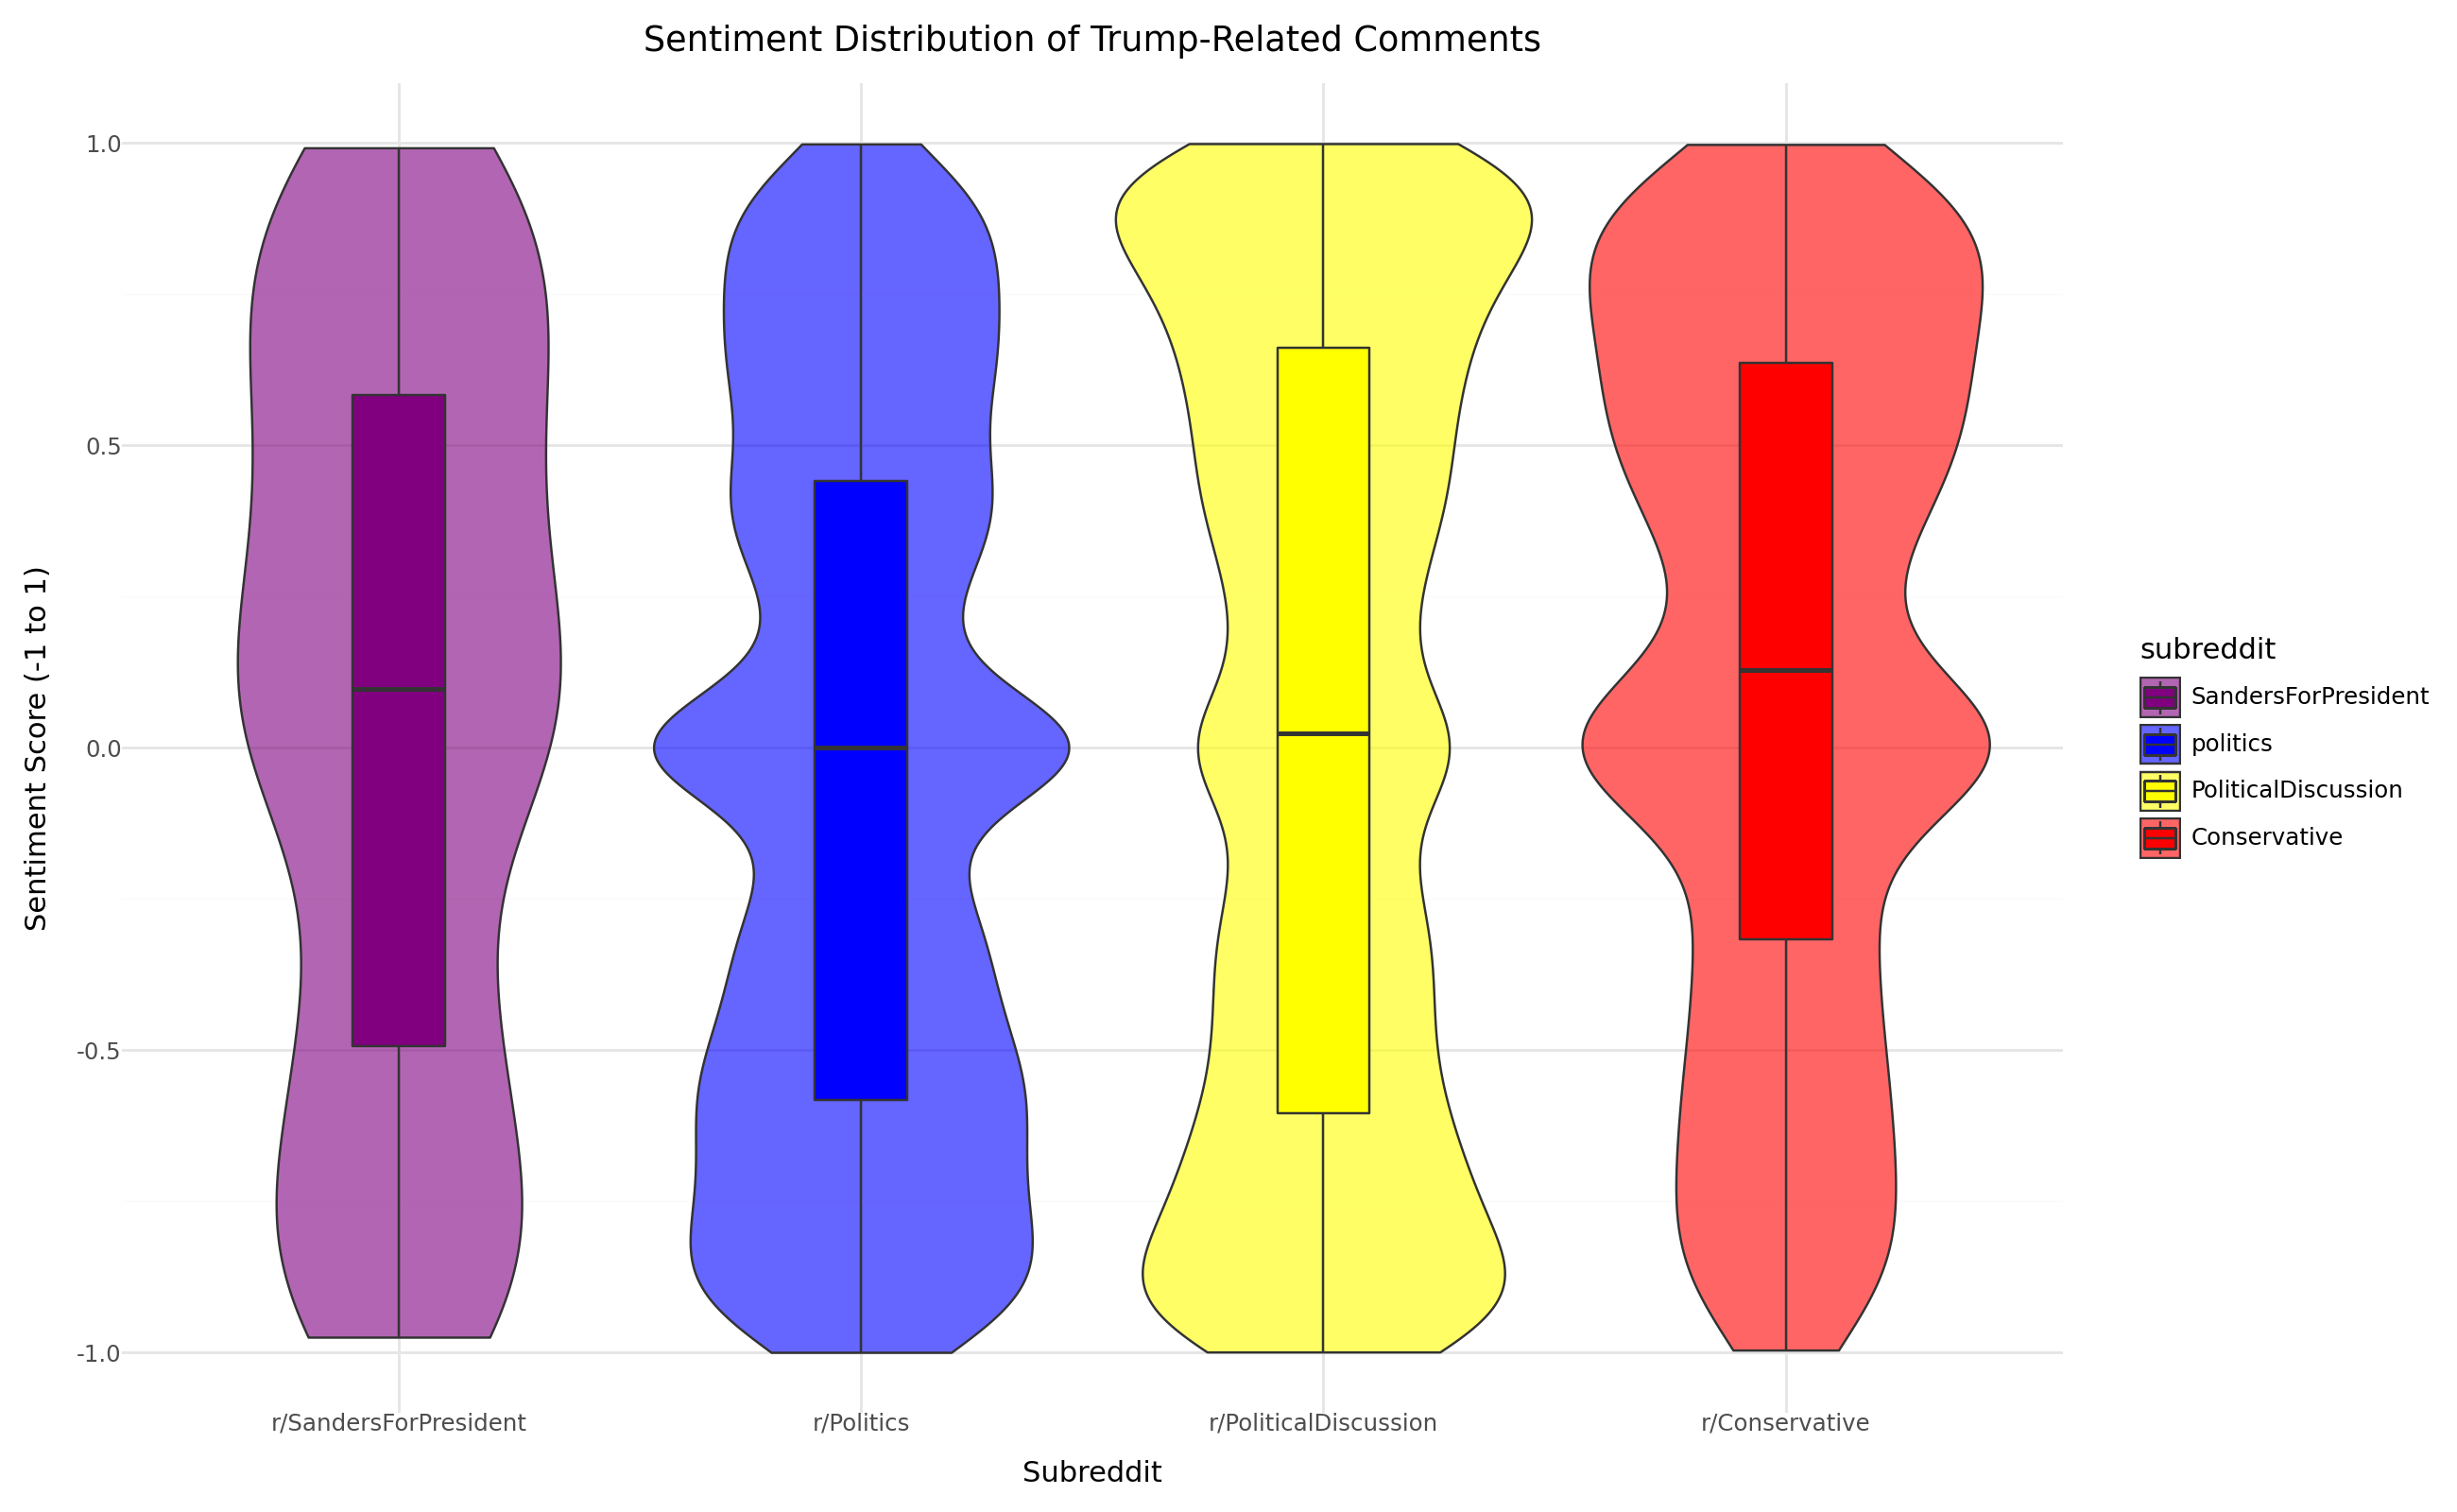

In [29]:
# Define the correct order of subreddits
subreddit_order = ["SandersForPresident", "politics", "PoliticalDiscussion", "Conservative"]

# Map the custom names
custom_labels = {
    "SandersForPresident": "r/SandersForPresident",
    "politics": "r/Politics",
    "PoliticalDiscussion": "r/PoliticalDiscussion",
    "Conservative": "r/Conservative"
}

# Convert subreddit column to categorical with the defined order
df_comments["subreddit"] = pd.Categorical(df_comments["subreddit"], categories=subreddit_order, ordered=True)

# Define custom colors for each subreddit
custom_colors = {
    "SandersForPresident": "purple",
    "politics": "blue",
    "PoliticalDiscussion": "yellow",
    "Conservative": "red"
}

# 📊 Sentiment Distribution by Subreddit

p1 = (
    ggplot(df_comments, aes(x="subreddit", y="comment_sentiment", fill="subreddit"))
    + geom_violin(alpha=0.6)
    + geom_boxplot(width=0.2, outlier_alpha=0.3)
    + ggtitle("Sentiment Distribution of Trump-Related Comments")
    + xlab("Subreddit")
    + ylab("Sentiment Score (-1 to 1)")
    + scale_x_discrete(labels=custom_labels)  # Apply custom names
    + scale_y_continuous(breaks=[-1, -0.5, 0.0, 0.5, 1])  # Custom Y-axis labels
    + scale_fill_manual(values=custom_colors)  # Apply custom colors
    + theme_minimal()
    + theme(figure_size=(13, 8))
)

p1


# 📊 Visualization 2

### Design choices
- **Clear Proportion Comparison**: Shows the relative distribution of sentiment categories across subreddits.
- **Highlights Sentiment Trends**: Easily identifies if a subreddit leans more negative, neutral, or positive.

### Explain insights
- As expected, r/Conservative had a high proportion of comments with positive sentiment in Trump-related posts and a low proportion of comments with negative sentiment
- As expected, r/politics had a low proportion of comments with positive sentiment in Trump-related posts and a high proportion of comments with negative sentiment
- Interestingly, r/PoliticalDiscussion had the highest proportion of comments with positive sentiments and the highest proportion of comments with negative sentiments, reflecting polarization




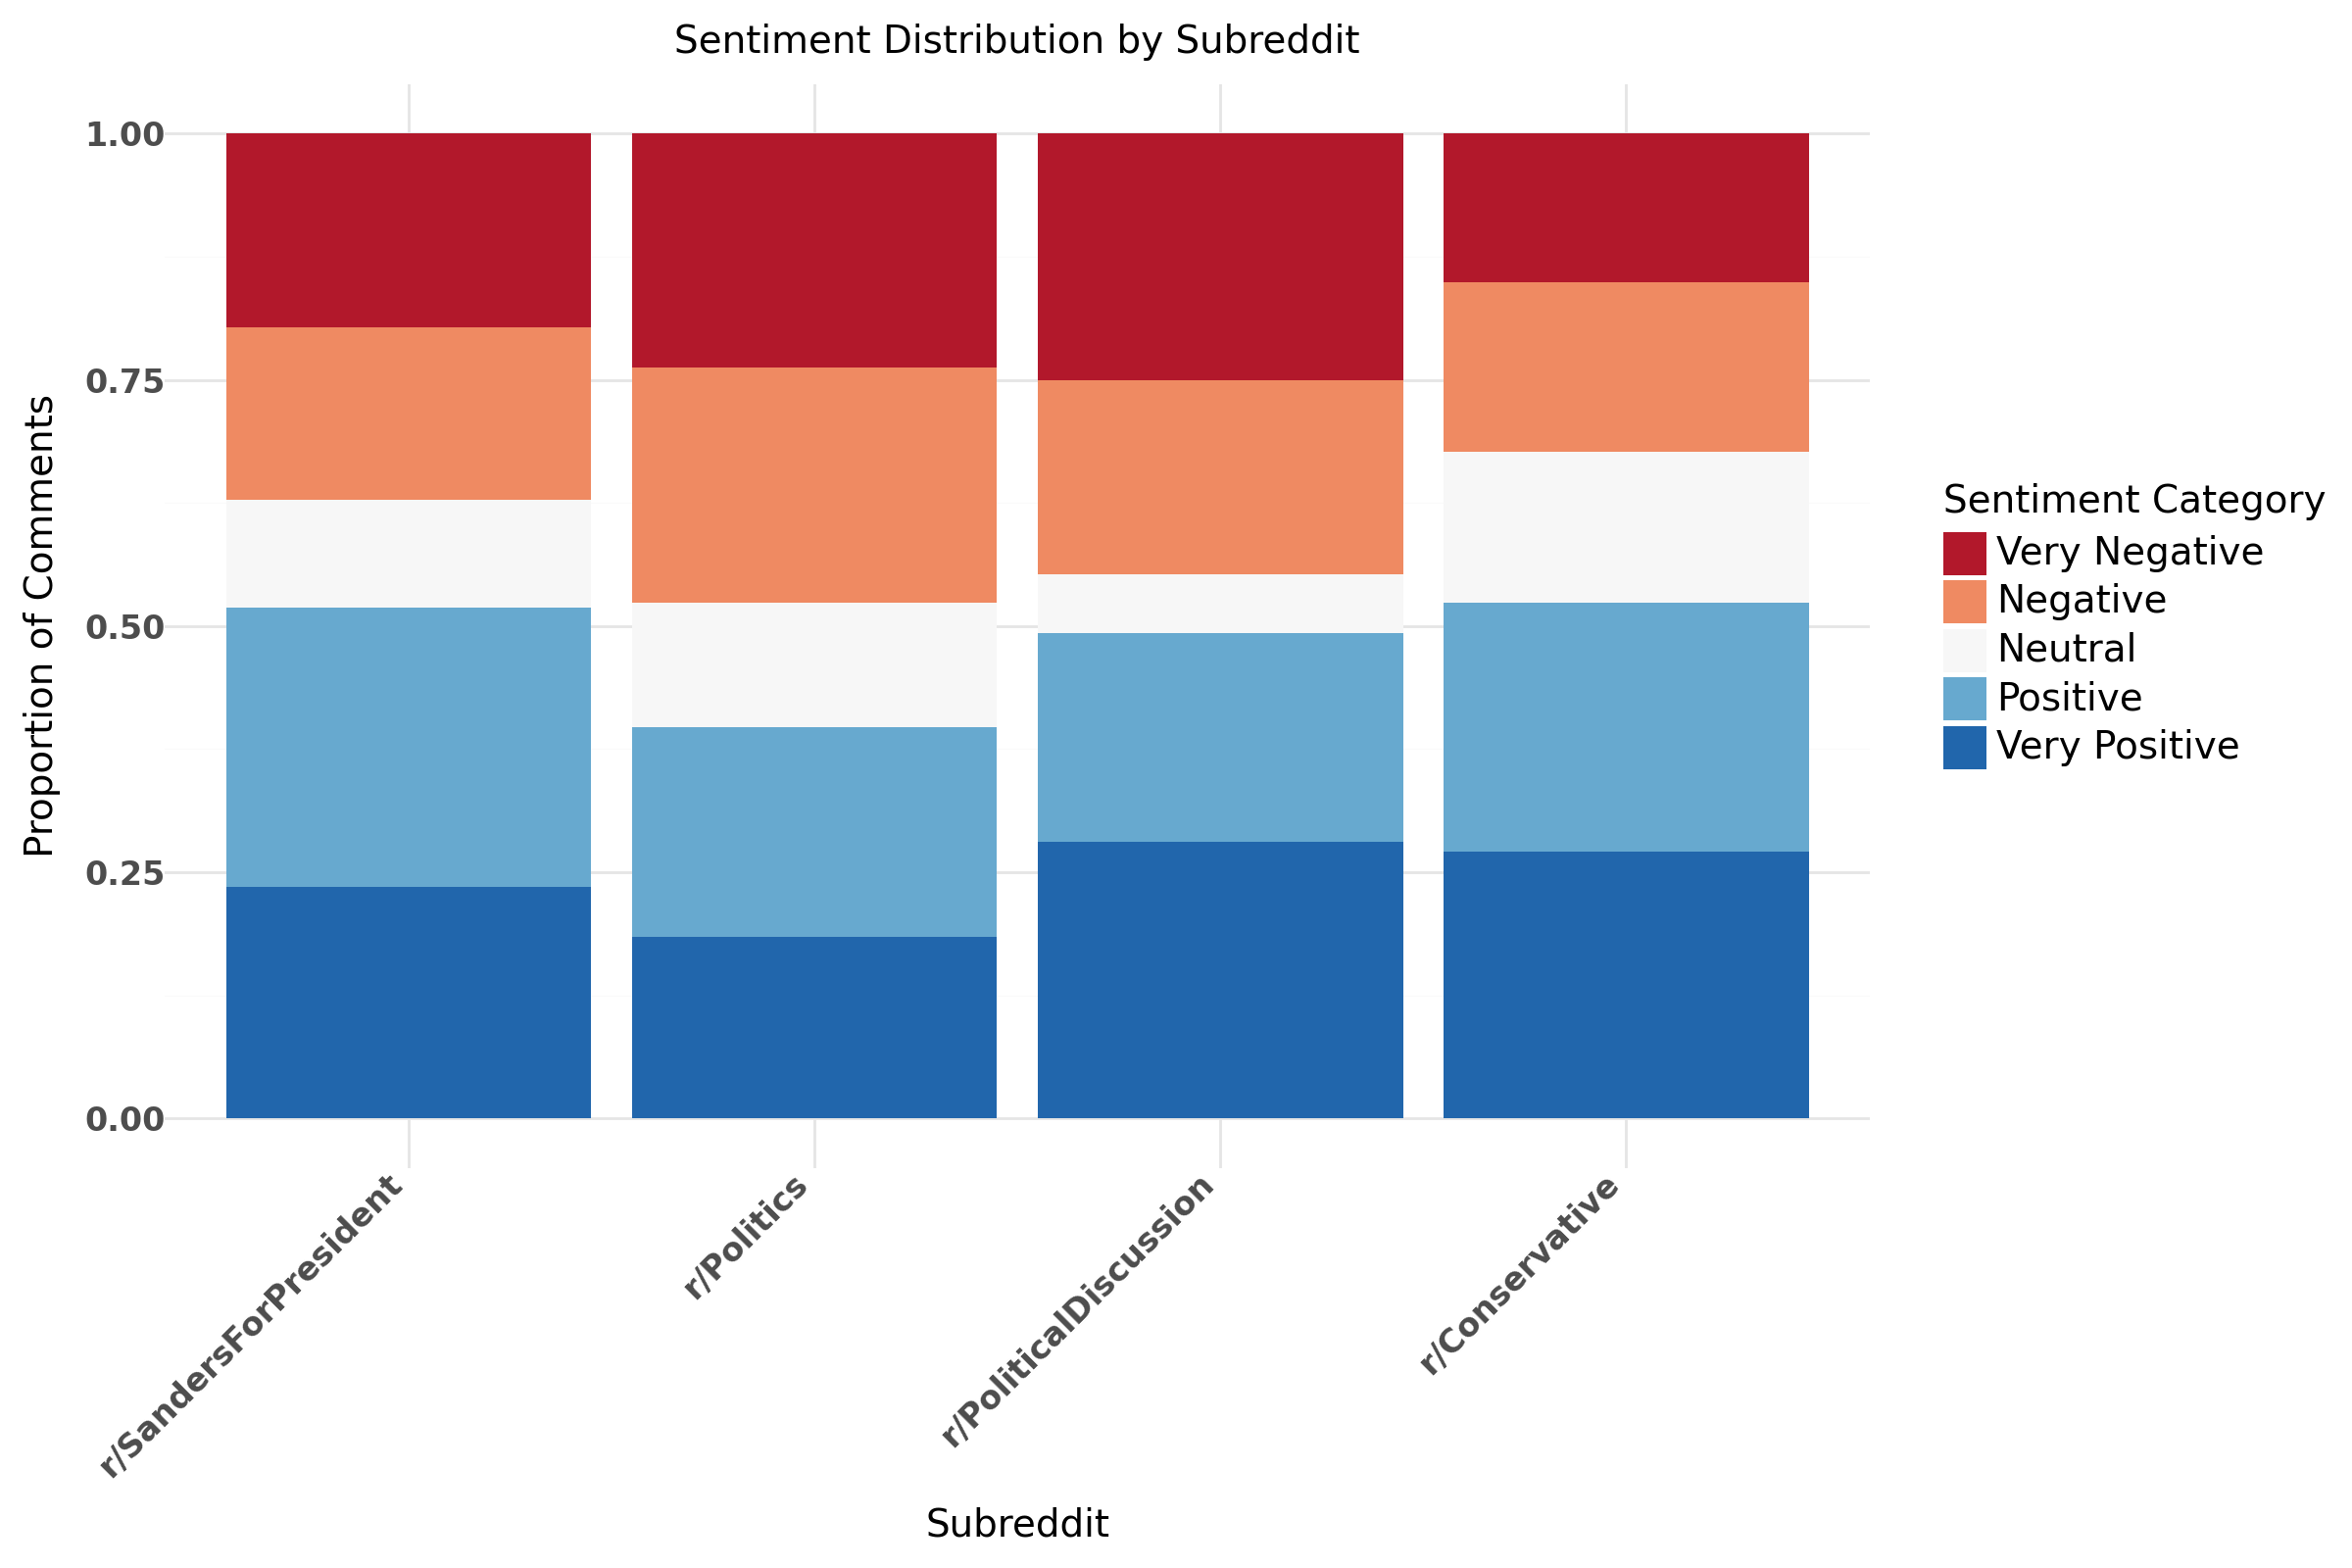

In [17]:
# Ensure Sentiment Categories are in Correct Order for Stacking (Bottom to Top)
df_sentiment_distribution["sentiment_category"] = pd.Categorical(
    df_sentiment_distribution["sentiment_category"], 
    categories=["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"], 
    ordered=True
)
custom_labels = {
    "SandersForPresident": "r/SandersForPresident",
    "politics": "r/Politics",
    "PoliticalDiscussion": "r/PoliticalDiscussion",
    "Conservative": "r/Conservative"
}
# Generate Stacked Bar Chart with Correct Order
p4 = (
    ggplot(df_sentiment_distribution, aes(x="subreddit", y="proportion", fill="sentiment_category"))
    + scale_x_discrete(labels=custom_labels)
    + geom_bar(stat="identity", position="stack")
    

    # Customize Title
    + ggtitle("Sentiment Distribution by Subreddit")

    # Customize Axis Labels
    + xlab("Subreddit")  
    + ylab("Proportion of Comments")  
    + theme(
        axis_title_x=element_text(size=14, weight="bold"),  
        axis_title_y=element_text(size=14, weight="bold")   
    )
    
    # Customize Legend
    + scale_fill_manual(values=SENTIMENT_COLORS, name="Sentiment Category")  
    + theme(
        legend_title=element_text(size=14, weight="bold"),  
        legend_text=element_text(size=12)  
    )
    
    # Customize Theme
    + theme_minimal()
    + theme(
        figure_size=(12, 8),
        axis_text_x=element_text(angle=45, ha="right", size=12, weight="bold"),  
        axis_text_y=element_text(size=12, weight="bold"),  
        text=element_text(size=14),  
        legend_position="right"  
    )
)

p4


# 📝 Conclusions

**Sentiment across subreddits**
   - **r/SandersForPresident** has a higher proportion of **positive Trump-related comments** and a lower proportion of **negative Trump-related comments**.
   - **r/Conservative** has a higher proportion of **positive Trump-related comments** and a lower proportion of **negative Trump-related comments**.
   - **r/politics** has a lower proportion of **positive Trump-related comments** and a higher proportion of **negative Trump-related comments**.
   - **r/PoliticalDiscussion** is more polarising, likely due to the fact that long discussion is encouraged and this attracts people with very strong views.
   

**Horseshoe Theory**

Most interestingly, I found that sentiment regarding Trump, at least in commments, in the leftist subreddit r/SandersForPresident, was almost as positive as r/Conservative. This seems to justify some form of the horseshoe theory - the notion that the far-left and far-right are closer to each other than to the political centre.


**Limitation**

The main limitation is that I could not randomise the selection of posts. Due to the way the API searches for posts (limited to Hot, Top, Controversial, New, Rising), searching for posts back during the election cycle that met the criteria of having 300 comments without being influenced by the number of upvotes on the post was impossible. That is why I settled on using Top to search for posts, but introducing random selection by only considering comments.